## **Practice Hyperparameter Tuning**

## **Import libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

## **Load dataset**

In [2]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### **Features Description**

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## **Simple EDA**

In [6]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['sex', 'smoker', 'region']

In [7]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['charges']))]
num_features

['age', 'bmi', 'children']

In [8]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in sex:  2
Unique values:  ['female' 'male']

Total unique values in smoker:  2
Unique values:  ['yes' 'no']

Total unique values in region:  4
Unique values:  ['southwest' 'southeast' 'northwest' 'northeast']



In [9]:
df.corr()['charges']

age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

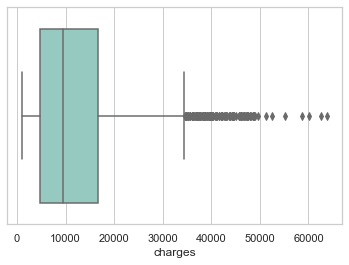

In [10]:
sns.set(style='whitegrid', palette='Set3')
sns.boxplot(x='charges', data=df);

### **Plot of categorical features**

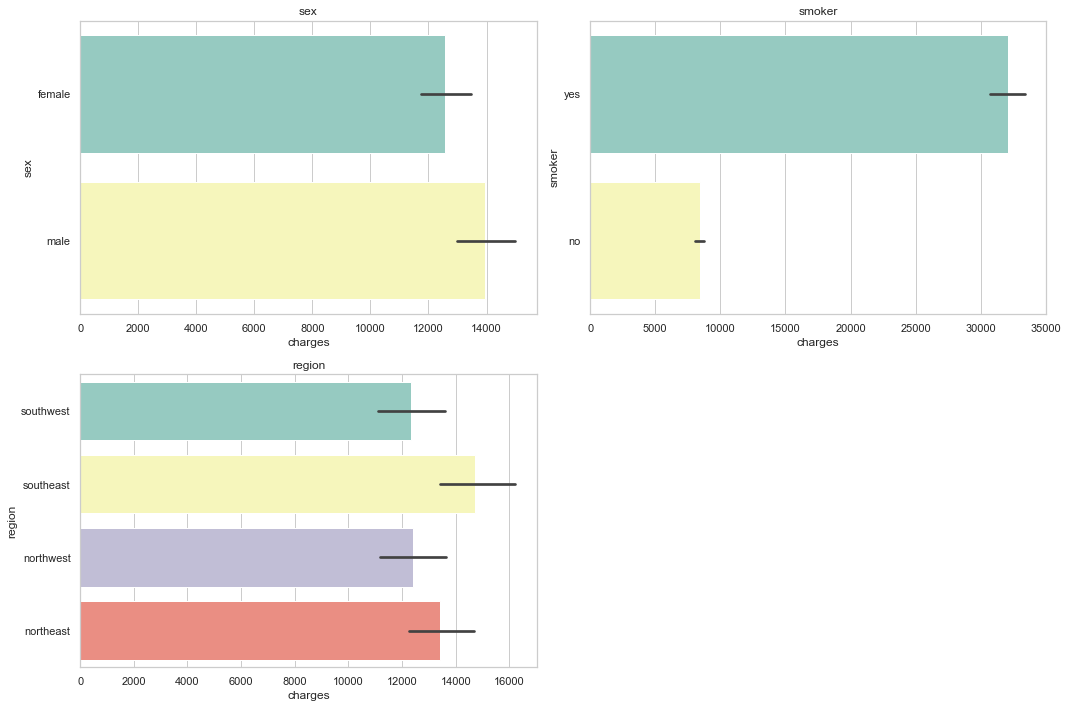

In [12]:
plt.figure(figsize=(15, 10), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1

for feature in cat_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.barplot(x = 'charges', y = feature, data = df)
    plt.xlabel('charges')
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout()

### **Plot of numerical features**

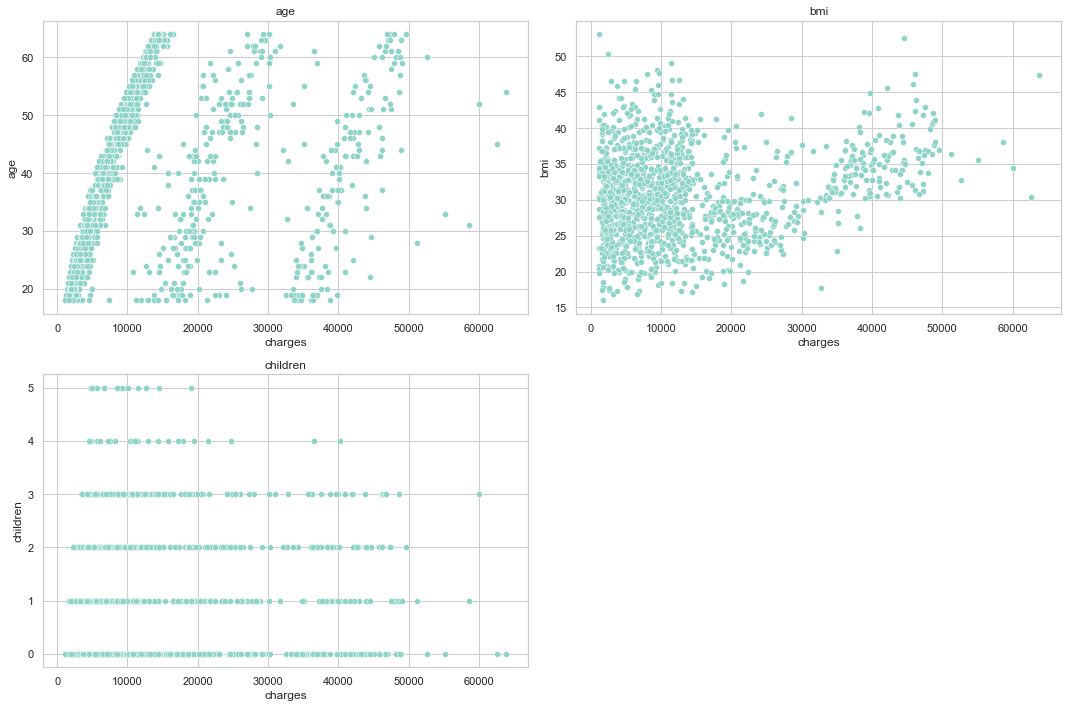

In [14]:
plt.figure(figsize=(15, 10), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1

for feature in num_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.scatterplot(x = 'charges', y = feature, data = df)
    plt.xlabel('charges')
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout()

## **Data Splitting**

In [15]:
# Define X and y
X = df.drop(columns='charges')
y = df['charges']

In [16]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=0
)

## **Data Pre-processing**

In [17]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'), ['sex', 'smoker', 'region']),
    ('scaler', RobustScaler(), ['age', 'bmi', 'children'])
], remainder='passthrough')

In [18]:
X_train_preprocessed = transformer.fit_transform(X_train)
X_test_preprocessed = transformer.transform(X_test)

## **Model benchmark**

In [19]:
# Define the models
linreg = LinearRegression(fit_intercept=True)
knn = KNeighborsRegressor(n_neighbors=5)
tree = DecisionTreeRegressor(criterion='mae', max_depth=5, random_state=0)

In [20]:
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [21]:
models = [linreg, knn, tree]
nilai_mean = []
nilai_std = []

for i in models:
    model_cv = cross_val_score(i, X_train_preprocessed, y_train, scoring = 'neg_mean_absolute_error')
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [22]:
pd.DataFrame({
    'model':['Linear Regression', 'KNN Regressor', 'Decision Tree Regressor'],
    'mean': nilai_mean,
    'std': nilai_std
})

,model,mean,std
0,Linear Regression,-4275.591651,276.448853
1,KNN Regressor,-3756.108785,409.944548
2,Decision Tree Regressor,-2140.367028,298.210629


### **Interpretation**

Of the three models tested, it turns out that the decision tree regressor model produces the smallest error, with a significant difference. Henceforth, only the decision tree regressor model will be tested in the test set and tuning is also carried out.

## **Model performance in test set**

In [23]:
estimator= Pipeline([
    ('preprocess', transformer),
    ('model', tree)
])
estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'region']),
                                                 ('scaler', RobustScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('model',
                 DecisionTreeRegressor(criterion='mae', max_depth=5,
                                       random_state=0))])

In [24]:
y_pred = estimator.predict(X_test)

In [25]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)

MSE: 24249019.226462997
RMSE: 4924.329317426181
MAE: 1985.4698345485076


## **Hyperparameter Tuning**

In [26]:
hyperparam_space= {
    'min_samples_leaf':[1, 5, 10, 15, 20, 50], # benchmark 1
    'max_depth':[2, 3, 4, 5, 6, 7], # benchmark 5
    'criterion':['mse', 'mae'] # benchmark mae
}

In [27]:
tree = DecisionTreeRegressor(criterion='mae', max_depth=5, random_state=0)

grid_search = GridSearchCV(
    tree, # model to tune
    param_grid = hyperparam_space, # hyperparam space
    scoring = 'neg_mean_absolute_error', # metric
    n_jobs= -1
)

In [28]:
grid_search.fit(X_train_preprocessed, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(criterion='mae', max_depth=5,
                                             random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 50]},
             scoring='neg_mean_absolute_error')

In [29]:
print(grid_search.best_score_)
print(grid_search.best_params_)

-1939.4536536028038
{'criterion': 'mae', 'max_depth': 6, 'min_samples_leaf': 5}


In [30]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007036,0.003093,0.001809,0.000841,mse,2,1,"{'criterion': 'mse', 'max_depth': 2, 'min_samp...",-3356.364053,-3188.168339,-3457.979143,-3190.628399,-3843.602398,-3407.348467,241.034390,67
1,0.007825,0.001750,0.000603,0.001206,mse,2,5,"{'criterion': 'mse', 'max_depth': 2, 'min_samp...",-3356.364053,-3188.168339,-3457.979143,-3190.628399,-3843.602398,-3407.348467,241.034390,67
2,0.007050,0.002320,0.001456,0.000841,mse,2,10,"{'criterion': 'mse', 'max_depth': 2, 'min_samp...",-3356.364053,-3188.168339,-3457.979143,-3190.628399,-3843.602398,-3407.348467,241.034390,67
3,0.005291,0.001493,0.000990,0.000685,mse,2,15,"{'criterion': 'mse', 'max_depth': 2, 'min_samp...",-3356.364053,-3188.168339,-3457.979143,-3190.628399,-3843.602398,-3407.348467,241.034390,67
4,0.003305,0.001740,0.002134,0.002295,mse,2,20,"{'criterion': 'mse', 'max_depth': 2, 'min_samp...",-3356.364053,-3188.168339,-3457.979143,-3190.628399,-3843.602398,-3407.348467,241.034390,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.056161,0.004368,0.001521,0.001916,mae,7,5,"{'criterion': 'mae', 'max_depth': 7, 'min_samp...",-1864.961894,-1605.538089,-1886.771645,-1878.334412,-2521.859691,-1951.493146,303.984088,2
68,0.049400,0.002559,0.002677,0.002654,mae,7,10,"{'criterion': 'mae', 'max_depth': 7, 'min_samp...",-1838.377226,-1693.533349,-1824.945265,-1890.404402,-2525.466208,-1954.545290,292.739873,3
69,0.048572,0.004632,0.001414,0.001508,mae,7,15,"{'criterion': 'mae', 'max_depth': 7, 'min_samp...",-1836.121452,-1752.811728,-1918.411131,-2002.681131,-2599.106583,-2021.826405,300.389377,5
70,0.045715,0.002668,0.001223,0.000930,mae,7,20,"{'criterion': 'mae', 'max_depth': 7, 'min_samp...",-1932.191237,-1806.718080,-1957.108446,-2067.890371,-2679.904188,-2088.762464,307.011578,9


## **Comparison of before and after tuning**

In [31]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_preprocessed, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=6, min_samples_leaf=5,
                      random_state=0)

In [32]:
y_pred_best = best_model.predict(X_test_preprocessed)

In [33]:
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

print('MSE:', mse_best)
print('RMSE:', rmse_best)
print('MAE:', mae_best)

MSE: 16994102.233397037
RMSE: 4122.390354320783
MAE: 1678.1435176455223


In [34]:
pd.DataFrame({
    'Model':['Decision Tree Regressor'],
    'RMSE before tuning': rmse,
    'MAE before tuning': mae,
    'RMSE after tuning': rmse_best,
    'MAE after tuning': mae_best
})

,Model,RMSE before tuning,MAE before tuning,RMSE after tuning,MAE after tuning
0,Decision Tree Regressor,4924.329317,1985.469835,4122.390354,1678.143518


## **Interpretation**

From the table above, it can be seen that the performance of the model increased after hyperparameter tuning was performed using only a few hyperparameters (RMSE and MAE values ​​were smaller after tuning).